In [1]:
import os
import torch
import scipy.io
import torch.nn as nn  # Import nn module
import torch.optim as optim  # Import optim module
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from hyperspectral_dataset import HyperspectralDataset, compute_statistics, NormalizeCube, NormalizeProfile

from ResNet import CustomResNet50  # Assuming ResNet50 is defined in ResNet.py

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Function to get all file paths from a dataset
def get_all_file_paths(dataset):
    file_paths = []
    for idx in range(len(dataset)):
        file_paths.append(dataset.get_image_path(idx))
    return file_paths

# # Initialize the dataset with transformations
dataset = HyperspectralDataset(root_dir='../../ummdsRP/all')
# channel_means_cube, channel_stds_cube, channel_means_profile, channel_stds_profile = compute_statistics(dataset)

channel_means_cube, channel_stds_cube, channel_means_profile, channel_stds_profile = [0.5] * 31, [0.5] * 31, [0.5] * 31, [0.5] * 31
# Define the custom transformations using the computed statistics
cube_transform = NormalizeCube(mean=channel_means_cube, std=channel_stds_cube)
profile_transform = NormalizeProfile(mean=channel_means_profile, std=channel_stds_profile)

# Apply the custom transforms to the datasets
train_dataset = HyperspectralDataset(root_dir='../../ummdsRP/train', cube_transform=cube_transform, profile_transform=profile_transform)
val_dataset = HyperspectralDataset(root_dir='../../ummdsRP/val', cube_transform=cube_transform, profile_transform=profile_transform)
test_dataset = HyperspectralDataset(root_dir='../../ummdsRP/test', cube_transform=cube_transform, profile_transform=profile_transform)

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=48, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=48, shuffle=False, num_workers=4)

Label mapping: {'GP': 0, 'GN': 1}
Label mapping: {'GP': 0, 'GN': 1}
Label mapping: {'GP': 0, 'GN': 1}
Label mapping: {'GP': 0, 'GN': 1}


In [3]:
# Get file paths for the main dataset and each split
main_dataset_paths = get_all_file_paths(dataset)
train_dataset_paths = get_all_file_paths(train_dataset)
val_dataset_paths = get_all_file_paths(val_dataset)
test_dataset_paths = get_all_file_paths(test_dataset)

# Check if the total length of the splits equals the length of the main dataset
total_split_length = len(train_dataset_paths) + len(val_dataset_paths) + len(test_dataset_paths)
if total_split_length != len(main_dataset_paths):
    print(f"Error: Total length of splits ({total_split_length}) does not equal length of main dataset ({len(main_dataset_paths)})")
else:
    print("Total length of splits matches the length of the main dataset.")

# Check for overlaps between splits
def check_for_overlaps(paths1, paths2):
    overlaps = set(paths1) & set(paths2)
    return overlaps

train_val_overlaps = check_for_overlaps(train_dataset_paths, val_dataset_paths)
train_test_overlaps = check_for_overlaps(train_dataset_paths, test_dataset_paths)
val_test_overlaps = check_for_overlaps(val_dataset_paths, test_dataset_paths)

if train_val_overlaps:
    print(f"Error: Overlaps found between train and validation datasets: {len(train_val_overlaps)} overlaps")
else:
    print("No overlaps found between train and validation datasets.")

if train_test_overlaps:
    print(f"Error: Overlaps found between train and test datasets: {len(train_test_overlaps)} overlaps")
else:
    print("No overlaps found between train and test datasets.")

if val_test_overlaps:
    print(f"Error: Overlaps found between validation and test datasets: {len(val_test_overlaps)} overlaps")
else:
    print("No overlaps found between validation and test datasets.")

Total length of splits matches the length of the main dataset.
No overlaps found between train and validation datasets.
No overlaps found between train and test datasets.
No overlaps found between validation and test datasets.


In [4]:
# Initialize the modified ResNet model
#model = ResNet50(num_classes=len(dataset.label_map), channels=31).to(device)  # Move model to GPU
model = CustomResNet50(num_classes=len(dataset.label_map)).to(device)
# model = pNet().to(device)

In [5]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience=5)



In [6]:
import time

# Initialize lists to store losses, accuracy, and learning rate change epochs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
lr_change_epochs = []

# Training and validation loop
num_epochs = 200  # Set the number of epochs
for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start timing the epoch

    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (cubes, _, labels) in enumerate(train_loader):
        cubes, labels = cubes.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(cubes)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for cubes, _, labels in val_loader:
            cubes, labels = cubes.to(device), labels.to(device)  # Move data to GPU
            outputs = model(cubes)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < current_lr:
        print(f"Learning rate reduced from {current_lr} to {new_lr}")
        lr_change_epochs.append(epoch+1)  # Log the epoch where the learning rate changed

    epoch_end_time = time.time()  # End timing the epoch
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f} seconds")

print("Training complete.")


Epoch [1/200], Loss: 0.6383, Training Accuracy: 72.84%
Validation Loss: 0.7006, Validation Accuracy: 70.38%
Epoch [1/200] completed in 39.35 seconds
Epoch [2/200], Loss: 0.4358, Training Accuracy: 82.59%
Validation Loss: 0.3024, Validation Accuracy: 87.25%
Epoch [2/200] completed in 38.76 seconds
Epoch [3/200], Loss: 0.4309, Training Accuracy: 82.38%
Validation Loss: 0.4049, Validation Accuracy: 84.75%
Epoch [3/200] completed in 39.93 seconds
Epoch [4/200], Loss: 0.4287, Training Accuracy: 82.99%
Validation Loss: 0.5386, Validation Accuracy: 76.75%
Epoch [4/200] completed in 40.52 seconds
Epoch [5/200], Loss: 0.3988, Training Accuracy: 84.40%
Validation Loss: 0.2913, Validation Accuracy: 87.50%
Epoch [5/200] completed in 40.49 seconds
Epoch [6/200], Loss: 0.4980, Training Accuracy: 82.09%
Validation Loss: 0.9269, Validation Accuracy: 76.75%
Epoch [6/200] completed in 88.90 seconds
Epoch [7/200], Loss: 0.4207, Training Accuracy: 84.63%
Validation Loss: 0.5646, Validation Accuracy: 81.25

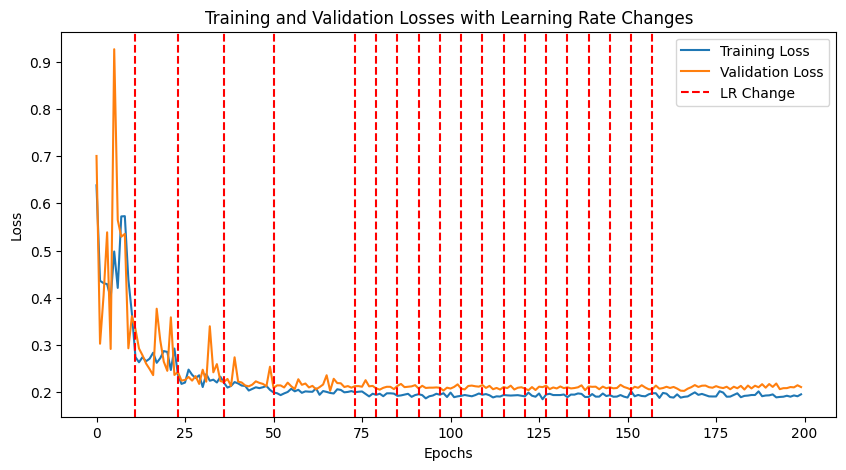

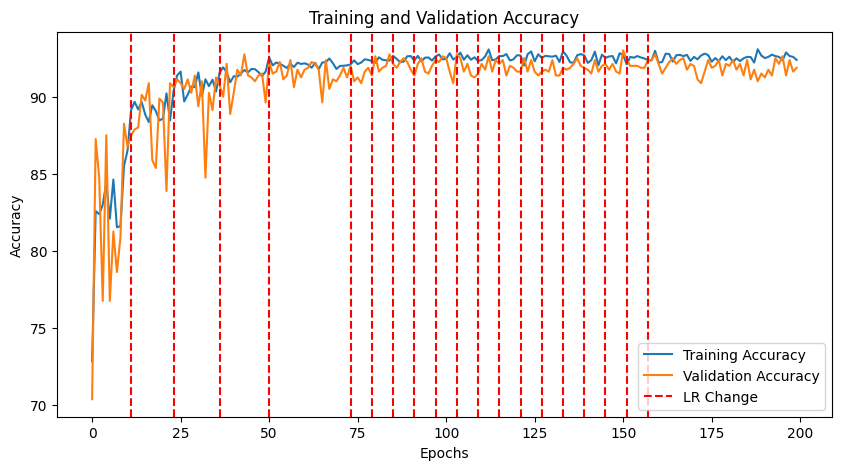

In [7]:
# Plot the training and validation losses with learning rate change points
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses with Learning Rate Changes')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [13]:
# Testing loop
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0 
with torch.no_grad():
    for inputs, _, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {accuracy:.2f}%")


Test Loss: 0.4601, Test Accuracy: 81.34%


In [12]:
# Function to test an individual sample from the test split
def test_individual_test_sample(sample_idx):
    # Load a specific sample from the test dataset
    cube, _, label = test_dataset[sample_idx]
    
    # Move the sample to GPU if using CUDA
    cube = cube.to(device).unsqueeze(0)  # Add batch dimension
    label = label.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient computation for inference
    with torch.no_grad():
        output = model(cube)
    
    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(output, dim=1)
    
    # Get the predicted class
    predicted_class = torch.argmax(probabilities, dim=1)
    
    # Print the results
    print(f"Predicted class: {predicted_class.item()}, Probability: {probabilities[0][predicted_class.item()]:.4f}")
    print(f"True label: {label.item()}")

# Test an individual sample from the test split (e.g., sample index 0)

for i in range(800):
    test_individual_test_sample(i)
    print('\n')


Predicted class: 0, Probability: 1.0000
True label: 0


Predicted class: 0, Probability: 0.9936
True label: 0


Predicted class: 0, Probability: 0.9988
True label: 0


Predicted class: 0, Probability: 0.9876
True label: 0


Predicted class: 0, Probability: 1.0000
True label: 0


Predicted class: 0, Probability: 1.0000
True label: 0


Predicted class: 0, Probability: 0.9871
True label: 0


Predicted class: 0, Probability: 1.0000
True label: 0


Predicted class: 0, Probability: 0.9993
True label: 0


Predicted class: 0, Probability: 0.9956
True label: 0


Predicted class: 0, Probability: 0.8464
True label: 0


Predicted class: 0, Probability: 0.9733
True label: 0


Predicted class: 0, Probability: 1.0000
True label: 0


Predicted class: 0, Probability: 1.0000
True label: 0


Predicted class: 0, Probability: 0.9999
True label: 0


Predicted class: 0, Probability: 0.9998
True label: 0


Predicted class: 0, Probability: 0.9975
True label: 0


Predicted class: 0, Probability: 0.9978
True lab

In [10]:
torch.save(model.state_dict(), 'resnet.pth')

In [11]:
for name, param in model.named_parameters():
    print(name)

resnet50.conv1.weight
resnet50.bn1.weight
resnet50.bn1.bias
resnet50.layer1.0.conv1.weight
resnet50.layer1.0.bn1.weight
resnet50.layer1.0.bn1.bias
resnet50.layer1.0.conv2.weight
resnet50.layer1.0.bn2.weight
resnet50.layer1.0.bn2.bias
resnet50.layer1.0.conv3.weight
resnet50.layer1.0.bn3.weight
resnet50.layer1.0.bn3.bias
resnet50.layer1.0.downsample.0.weight
resnet50.layer1.0.downsample.1.weight
resnet50.layer1.0.downsample.1.bias
resnet50.layer1.1.conv1.weight
resnet50.layer1.1.bn1.weight
resnet50.layer1.1.bn1.bias
resnet50.layer1.1.conv2.weight
resnet50.layer1.1.bn2.weight
resnet50.layer1.1.bn2.bias
resnet50.layer1.1.conv3.weight
resnet50.layer1.1.bn3.weight
resnet50.layer1.1.bn3.bias
resnet50.layer1.2.conv1.weight
resnet50.layer1.2.bn1.weight
resnet50.layer1.2.bn1.bias
resnet50.layer1.2.conv2.weight
resnet50.layer1.2.bn2.weight
resnet50.layer1.2.bn2.bias
resnet50.layer1.2.conv3.weight
resnet50.layer1.2.bn3.weight
resnet50.layer1.2.bn3.bias
resnet50.layer2.0.conv1.weight
resnet50.layer